In [1]:
import multiprocessing as mp
import os
import random as rn
import warnings
from glob import glob
from pathlib import Path

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timesynth as ts
import yfinance as yf
from IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from run import run_cmd

seed = 42
sns.set()

def reset_seed():
    os.environ["PYTHONHASHSEED"] = str(seed)
    rn.seed(seed)
    np.random.seed(seed)

In [2]:
data_name = "nyc_taxi"

Index(['timestamp', 'value'], dtype='object')
(10320, 2) 0


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


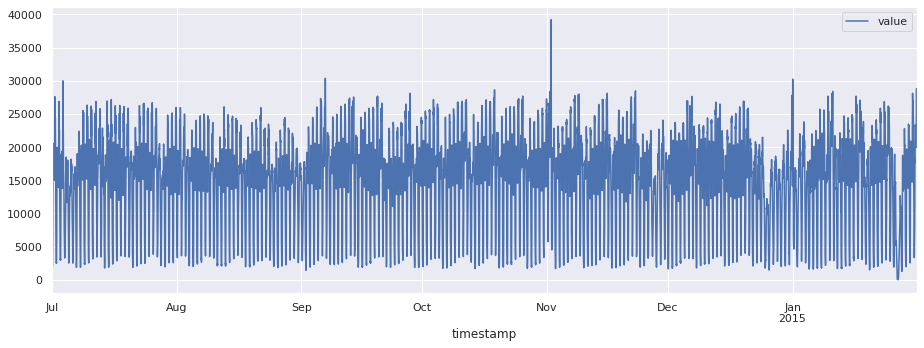

In [3]:
if data_name == "nyc_energy":
    data_path = "data/nyc_energy.csv"
    data = pd.read_csv(data_path)[:-81]
    dt, target = "timeStamp", "demand"
elif data_name == "nyc_taxi":
    data_path = "data/nyc_taxi.csv"
    data = pd.read_csv(data_path)
    dt, target = "timestamp", "value"

print(data.columns)
print(data.shape, data[target].isna().sum())

data[dt] = pd.to_datetime(data[dt])
data = data.set_index(dt)
data = data[[target]]
# data = data.resample("h").mean().interpolate()
# print(data.shape, data[target].isna().sum())
data = data.reset_index()

display(data)
data.plot(x=dt, y=target, figsize=(13, 5))
plt.tight_layout()
plt.show()

In [4]:
n_levels = 6
target_mean = data[target].mean()
target_std = data[target].std()

# data_fault_type = "white_noise"
# data_fault_type = "red_noise"
data_fault_type = "outliers"
# data_fault_type = "stuck-at"

# data_fault_params = dict(zip(np.arange(n_levels), target_std * np.linspace(0, 1.5, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, 4, num=n_levels)))
data_fault_params = dict(zip(np.arange(n_levels), np.linspace(0, .05, num=n_levels)))
# data_fault_params = dict(zip(np.arange(n_levels), np.arange(n_levels)))

n_test = np.round(.2*len(data)).astype(int)
n_train = len(data)-n_test
n_train, n_test

(8256, 2064)

In [5]:
def inject_white_noise(data, std):
    data_ = data.copy()
    data_[target] += ts.noise.GaussianNoise(std=std).sample_vectorized(data.index.values)
    return data_

def inject_red_noise(data, tau, std):
    data_ = data.copy()
    dummy_signal = ts.signals.Sinusoidal(frequency=0)
    noise_generator = ts.noise.RedNoise(std=std, tau=tau)
    timeseries = ts.TimeSeries(dummy_signal, noise_generator=noise_generator)
    data_[target] += timeseries.sample(data.index)[0]
    return data_

def inject_outliers(data, prob, mean, std):
    data_ = data.copy()
    n_outliers = np.round(prob*len(data)).astype(int)
    n_train_outliers = np.round(prob*n_train).astype(int)
    n_test_outliers = n_outliers-n_train_outliers
    train_outlier_idxs = rn.sample(range(n_train), n_train_outliers)
    test_outlier_idxs = rn.sample(range(n_train, len(data)), n_test_outliers)
    outlier_idxs = np.concatenate((train_outlier_idxs, test_outlier_idxs))
    data_[target][outlier_idxs] = 10 * std + mean
    return data_

def inject_stuck_at(data, level, mean, std):
    data_ = data.copy()
    if level == 0:
        return data_
    n_stuck_at = n_train // (n_levels - 1)
    start = (level - 1) * n_stuck_at
    end = start + n_stuck_at
    for i in range(start, end):
        data_[target][i] = 10 * std + mean
    return data_

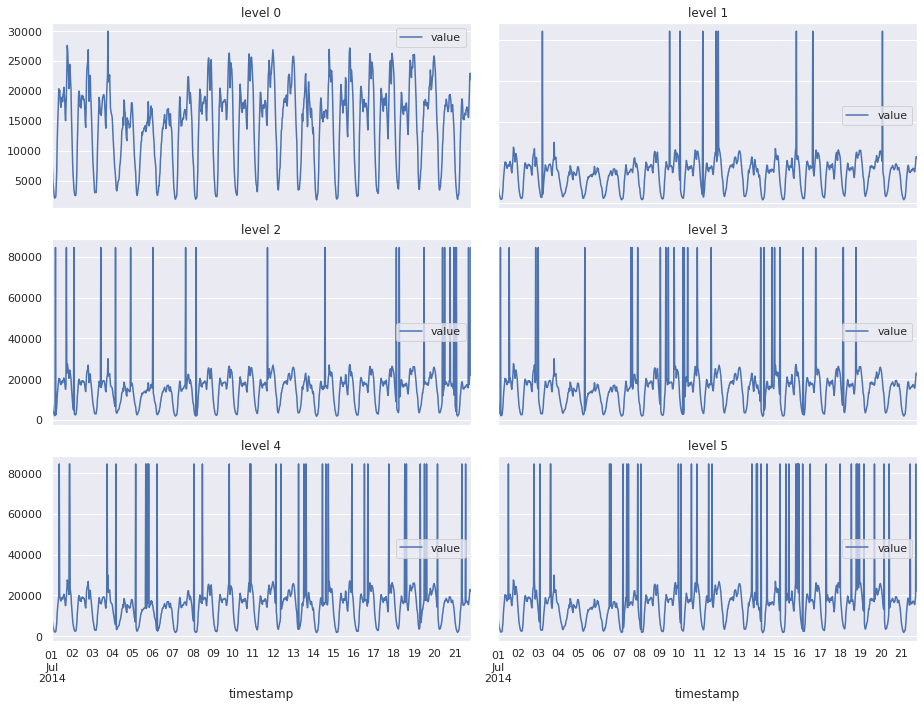

In [6]:
reset_seed()

n_subplot_rows = n_levels//2 if n_levels % 2 == 0 else n_levels//2+1
train_dfs, test_dfs, pred_dfs = dict(), dict(), dict()

fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(13, 10/3*n_subplot_rows))
for i in data_fault_params.keys():
    data_ = None
    if data_fault_type == "white_noise":
        data_ = inject_white_noise(data, data_fault_params[i])
    elif data_fault_type == "red_noise":
        data_ = inject_red_noise(data, data_fault_params[i], target_std)
    elif data_fault_type == "outliers":
        data_ = inject_outliers(data, data_fault_params[i], target_mean, target_std)
    elif data_fault_type == "stuck-at":
        data_ = inject_stuck_at(data, data_fault_params[i], target_mean, target_std)
    
    x_train, x_test, y_train, y_test = train_test_split(data_[dt].values, data_[target].values,
                                                        shuffle=False, test_size=n_test)
    train_dfs[i] = pd.DataFrame({dt: x_train, target: y_train})
    test_dfs[i] = pd.DataFrame({dt: x_test, target: y_test})

    train_dfs[i][:1000].plot(x=dt, y=target, ax=axes.flatten()[i], sharex=True, sharey=True,
                             title=f"level {i}")

    train_path = f"train/{Path(data_path).stem}_{data_fault_type}_level_{i}.csv"
    if not Path(train_path).exists():
        train_dfs[i].to_csv(train_path, index=False)
    else:
        train_df = pd.read_csv(train_path)
        assert np.allclose(train_df[target].values, train_dfs[i][target].values)
plt.tight_layout()
plt.show()

In [7]:
automl_names = ["analytics-zoo", "azure_automl", "tpot_automl"]
# automl_names = ["analytics-zoo"]
n_preds = 1
time_limit_min = 30

In [8]:
for automl_name in automl_names:
    pred_dfs[automl_name] = dict()
    for i in range(len(data_fault_params)):
        pred_dfs[automl_name][i] = list()
        pred_paths = glob(f"pred/{Path(data_path).stem}_{data_fault_type}_level_{i}_" \
                          f"{automl_name}_{time_limit_min}_min_*.csv")
        for pred_path in pred_paths[:n_preds]:
            df_pred = pd.read_csv(pred_path)
            df_pred.name = pred_path[-12:-4]
            df_pred[dt] = pd.to_datetime(df_pred[dt])
            pred_dfs[automl_name][i].append(df_pred)

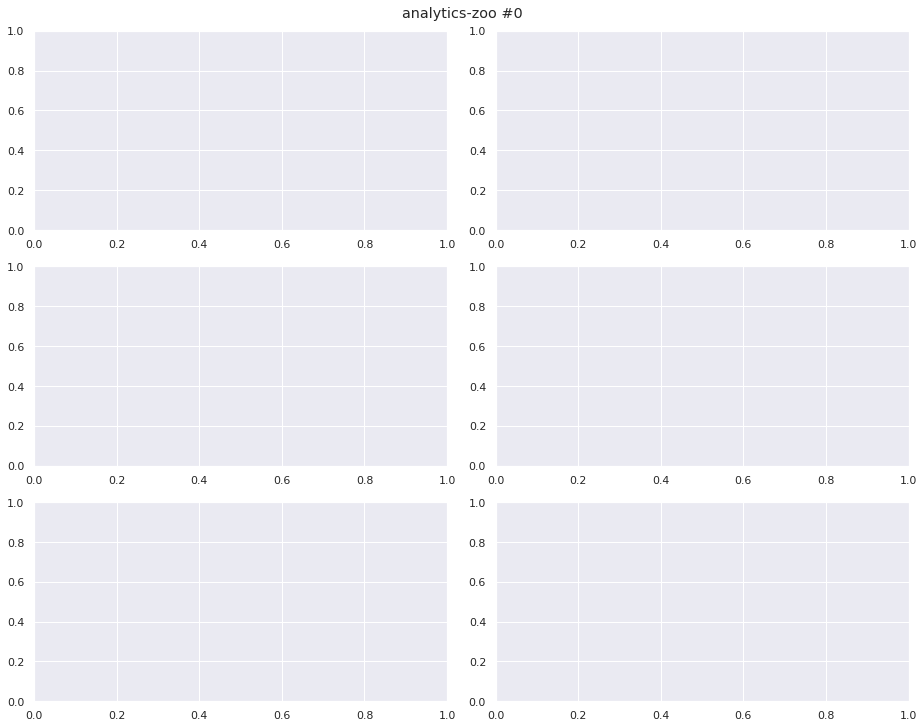

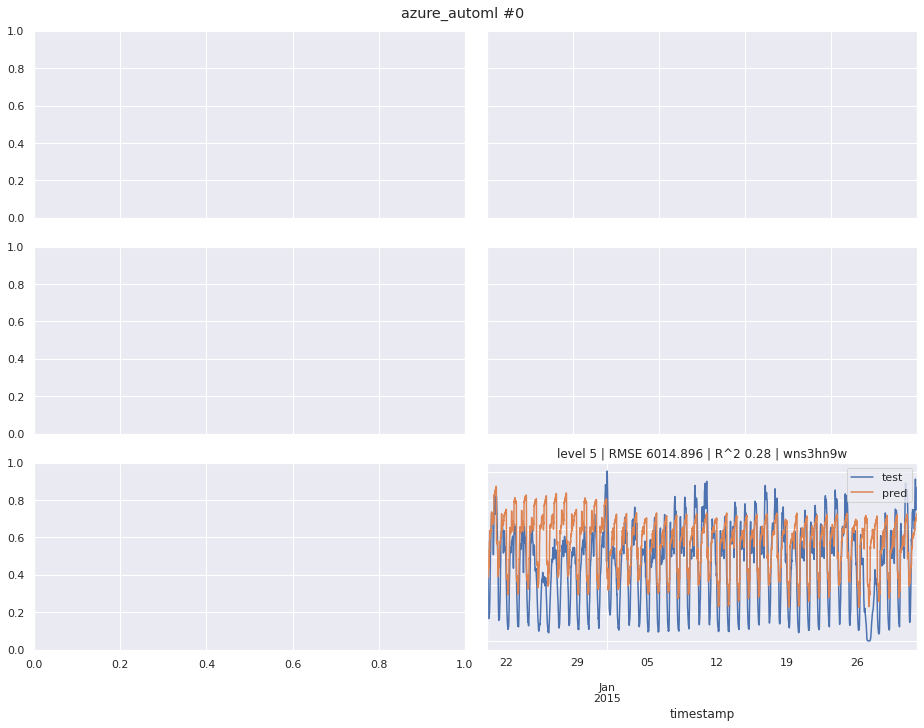

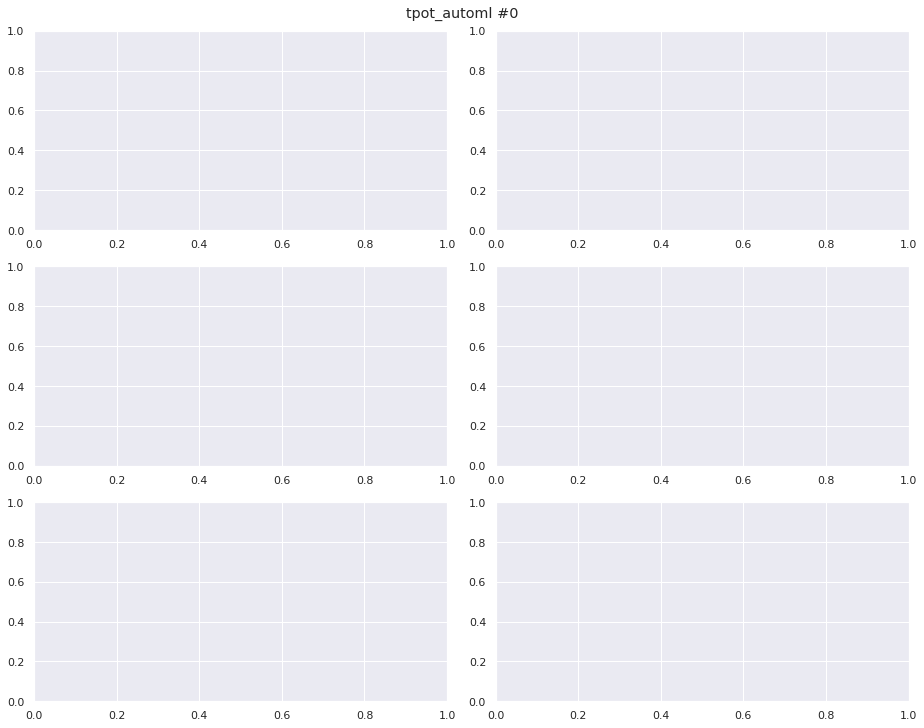

In [9]:
df_test = test_dfs[0]
metrics = []
for automl_name in automl_names:
    for i in range(n_preds):
        fig, axes = plt.subplots(n_subplot_rows, 2, figsize=(13, 10/3*n_subplot_rows))
        for j in data_fault_params.keys():
            try:
                df_pred = pred_dfs[automl_name][j][i]
            except:
                continue
            rmse = np.sqrt(mean_squared_error(df_test[target], df_pred[target]))
            r2 = r2_score(df_test[target], df_pred[target])
            metrics.append({"metric": "RMSE", "automl_name": automl_name, "level": j, "score": rmse})
            metrics.append({"metric": "R^2", "automl_name": automl_name, "level": j, "score": r2})
            df = pd.DataFrame({dt: df_test[dt], "test": df_test[target], "pred": df_pred[target]})
            df.name = automl_name
            df.plot(x=dt, ax=axes.flatten()[j], sharex=True, sharey=True,
                    title=f"level {j} | RMSE {np.round(rmse, 3)} | R^2 {np.round(r2, 3)} | " \
                          f"{df_pred.name}")
        plt.tight_layout()
        plt.suptitle(f"{automl_name} #{i}", y=1.01)
        plt.show()

RMSE,azure_automl
level,
5,6014.896387


R^2,azure_automl
level,
5,0.28034


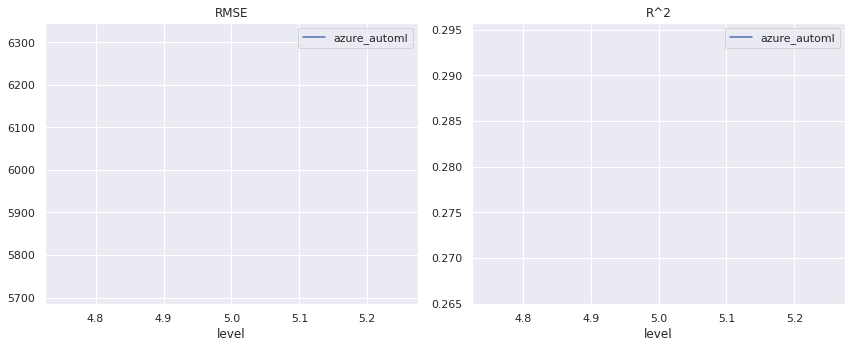

In [10]:
df_metrics = pd.DataFrame(metrics)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, metric in zip(axes.flatten(), ["RMSE", "R^2"]):
    df = df_metrics[df_metrics["metric"] == metric]
    df = df.groupby(["level", "automl_name"])["score"].aggregate("mean").unstack()
    df.columns.name = None
    df.plot(ax=ax, title=metric)
    df.columns.name = metric
    display(df)
plt.tight_layout()
plt.show()